In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import pandas as pd
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import XSD, RDFS, OWL
import networkx as nx
from owlready2 import *
import rdflib
from rdflib import Graph, Namespace, Literal, RDF, URIRef   # <-- RDFlib version overrides Owlready2
# Only import what you need from owlready2
from owlready2 import World
import networkx as nx
import pickle









# Knowledge Graph Construction

## Knowledge base (ABox) construction

This section builds the knowledge base (ABox) that sits on top of the ontology we designed in Protégé.

In Protégé, we created the TBox — the “brain” of the system — where we defined concepts such as Components, Faults, Symptoms, Causes, and Procedures, as well as the relationships between them.

Here, we take our raw CSV data and convert it into RDF triples so that every real-world item (a specific component, a recorded fault, a symptom, etc.) becomes a properly typed individual in the knowledge graph.

In [2]:
df_components = pd.read_csv('data/components.csv')
df_causes = pd.read_csv('data/causes.csv')
df_symptoms = pd.read_csv('data/symptoms.csv')
df_relations = pd.read_csv('data/relations.csv')
df_procedures = pd.read_csv('data/procedures.csv')

print("--- Data Inventory ---")
print(f"Components: {len(df_components)} (Physical parts)")
print(f"Failures:   {len(df_causes)} (Root causes)")
print(f"Symptoms:   {len(df_symptoms)} (Observable effects)")
print(f"Relations:  {len(df_relations)} (Logic links)")
print(f"Procedures: {len(df_procedures)} (Fixes)")

--- Data Inventory ---
Components: 5 (Physical parts)
Failures:   4 (Root causes)
Symptoms:   3 (Observable effects)
Relations:  8 (Logic links)
Procedures: 4 (Fixes)


First, we import the necessary libraries and initialize the RDF Graph.

Crucially, we bind the gjoli namespace to http://example.org/gjoli_diagnostics#. This ensures that every piece of data we create here matches the "address" of the rules in our Protegé schema

In [3]:

g = Graph()

CNC = Namespace("http://example.org/gjoli_diagnostics#")
g.bind("gjoli", CNC)


In [4]:
# 2. Define Root Machine
# We create the main machine instance that holds all components.
machine_uri = CNC["CNC_Machine_01"]
g.add((machine_uri, RDF.type, CNC.Machine))



<Graph identifier=N491e201b612948af842ddba2a919d508 (<class 'rdflib.graph.Graph'>)>

**Step 2**: Mapping Physical Components

In this section, we process the Physical Hierarchy of the machine.

We perform two passes here:

- **Creation**: We loop through df_components to create the nodes (Entities) and assign them the type CNC.Component. We also build a dictionary (comp_id_map) to remember which ID belongs to which URI.

- **Linking**: We loop again to connect children to parents. If a component has no parent, we attach it directly to the main Machine.

In [5]:
# ---------------------------------------------------------
# A. COMPONENTS (Physical Hierarchy)
# ---------------------------------------------------------
comp_id_map = {}
for _, row in df_components.iterrows():
    safe_name = row['name'].replace(" ", "")
    comp_uri = CNC[safe_name]
    comp_id_map[row['component_id']] = comp_uri
    g.add((comp_uri, RDF.type, CNC.Component))
    
for _, row in df_components.iterrows():
    child_uri = CNC[row['name'].replace(" ", "")]
    if pd.isna(row['parent_component']):
        g.add((machine_uri, CNC.hasComponent, child_uri))
    else:
        parent_id = row['parent_component']
        if parent_id in comp_id_map:
            parent_uri = comp_id_map[parent_id]
            g.add((parent_uri, CNC.hasComponent, child_uri))

**Step 3:** Failures, Symptoms, and "Logic Injection"

Here we map the diagnostic concepts: Failures (Causes) and Symptoms.

**The Logic Injection**: This is where we make the graph "smart." The CSV data contains raw text like "High Vibration." We convert this into a semantic tag: hasSeverityLevel = "High"

In [6]:
# ---------------------------------------------------------
# B. FAILURES ("FailureMode") & SYMPTOMS
# ---------------------------------------------------------
for _, row in df_symptoms.iterrows():
    sym_name = row['name'].replace(" ", "")
    sym_uri = CNC[sym_name]
    
    # FIX 1: Explicitly Type the Overheat Symptom
    # If this is the overheat symptom, we must tell the AI it belongs to the 
    # specific 'SpindleOverheat' class, otherwise the OverheatedMachine rule fails.
    if "Overheat" in sym_name:
        g.add((sym_uri, RDF.type, CNC.SpindleOverheat)) 
    
    # It is also a generic Symptom
    g.add((sym_uri, RDF.type, CNC.Symptom))
    
    # Severity Logic
    if "High" in sym_name or "Overheat" in sym_name:
        g.add((sym_uri, CNC.hasSeverityLevel, Literal("High", datatype=XSD.string)))
    else:
        g.add((sym_uri, CNC.hasSeverityLevel, Literal("Low", datatype=XSD.string)))

**Step 4:** Procedures and Cost Analysis

In this block, we map the Maintenance Actions.

We explicitly add data properties for sparePartsCost and hasDurationHours. This data allows the Reasoner to execute the Costly Repair rule (e.g., "Any action costing > €500 is a CostlyRepair").

In [7]:
# ---------------------------------------------------------
# C. PROCEDURES (Actions, Costs, & LINKAGE)
mitigation_map = {
    "Bearing Wear": "BearingWearHigh",  
    "Fan Fault": "FanFault",
    "Clogged Filter": "CloggedFilter",
    "Low Cooling Efficiency": "LowCoolingEfficiency"
}

for _, row in df_procedures.iterrows():
    proc_uri = CNC[row['name'].replace(" ", "")]
    g.add((proc_uri, RDF.type, CNC.MaintenanceAction)) 
    
    # 1. Properties
    g.add((proc_uri, CNC.sparePartsCost, Literal(row['spare_parts_cost_eur'], datatype=XSD.float)))
    g.add((proc_uri, CNC.hasDurationHours, Literal(row['effort_h'], datatype=XSD.float)))

    # 2. DYNAMIC LINK: Action -> Mitigates -> Failure
    if 'mitigates_cause' in row and pd.notna(row['mitigates_cause']):
        raw_cause = row['mitigates_cause']
        
        # Check if we have a special mapping for this name
        if raw_cause in mitigation_map:
            safe_cause_name = mitigation_map[raw_cause]
        else:
            # Fallback: Just remove spaces (Works for "Fan Fault" -> "FanFault")
            safe_cause_name = raw_cause.replace(" ", "")
            
        cause_uri = CNC[safe_cause_name]
        g.add((proc_uri, CNC.mitigates, cause_uri))

**Step 5**: Defining Relationships (The Graph Structure)

Here we connect all the nodes we created. The CSV uses simple text terms like causesSymptom. We map these to the formal Object Properties defined in our Ontology (e.g., manifestsAs).

In [8]:
# ---------------------------------------------------------
# D. RELATIONS (The Logic)
# ---------------------------------------------------------
pred_map = {
    'causesSymptom': CNC.manifestsAs,
    'affectsComponent': CNC.affectsComponent,
    'mitigatesCause': CNC.mitigates,
    'targetsComponent': CNC.targetsComponent
}

for _, row in df_relations.iterrows():
    subj = CNC[row['subj'].replace(" ", "")]
    obj = CNC[row['obj'].replace(" ", "")]
    pred_str = row['pred']
    
    if pred_str in pred_map:
        g.add((subj, pred_map[pred_str], obj))

**Step 6:** The "Overheated Machine" Scenario - **PURELY FOR TESTING**


We manually add a triple that links CNC_Machine_01 directly to SpindleOverheat. This acts as a "sensor trigger." When the Reasoner sees this link, it will match the OverheatedMachine rule and raise the alert.


In a fully deployed system, the Bayesian Network would analyze the 'telemetry.csv' file, calculate a probability, and IF the probability is high (e.g., > 90%), it would insert this link automatically. For this Knowledge Graph prototype, we "SIMULATE" that detection event by manually injecting the triple. This proves that our Logic (TBox) correctly handles the alert once the data (ABox) arrives.

In [9]:
# ---------------------------------------------------------
# E. CRITICAL OVERHEAT SCENARIO
# ---------------------------------------------------------
# Force the link for OverheatedMachine logic
# We use 'SpindleOverheat' to match the hasValue rule in your Schema
symptom_uri = CNC["SpindleOverheat"] 
g.add((machine_uri, CNC.hasSymptom, symptom_uri))

<Graph identifier=N491e201b612948af842ddba2a919d508 (<class 'rdflib.graph.Graph'>)>

Finally, we exported  the final graph to Turtle format

In [10]:
output_file = "ontologies/knowledge_base_protege.ttl"
g.serialize(destination=output_file, format="turtle")
print(f"SUCCESS: Data graph saved to {output_file} using namespace {CNC}")

SUCCESS: Data graph saved to ontologies/knowledge_base_protege.ttl using namespace http://example.org/gjoli_diagnostics#


## 4.1 Knowledge Graph visualization

For the hypothetical CNC_Machine_01 ( Overheated ) we manually defined

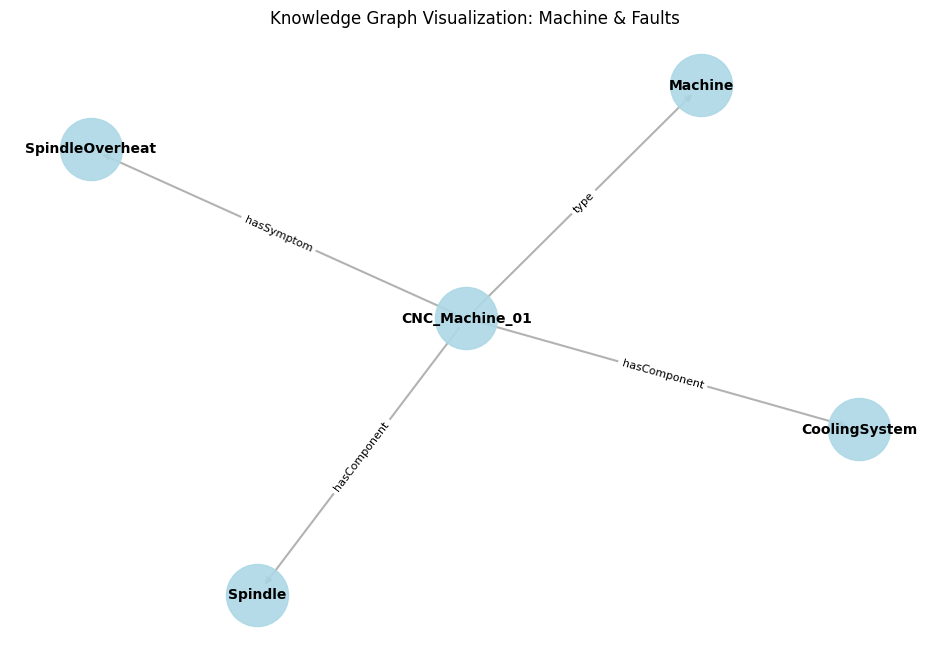

In [12]:
g.parse("ontologies/knowledge_base_protege.ttl", format="turtle")

# 2. Create a NetworkX graph for visualization
G = nx.DiGraph()

# 3. Filter: Only visualize things connected to the Machine or Failures
# (Plotting all triples can be too messy)
CNC = Namespace("http://example.org/gjoli_diagnostics#")
focus_node = CNC["CNC_Machine_01"]

for s, p, o in g:
    # Convert URIs to short labels (e.g., 'CNC_Machine_01')
    s_label = s.split("#")[-1]
    o_label = o.split("#")[-1]
    
    # Logic: Only show paths connected to the Machine OR Failures
    if (s == focus_node) or (o == focus_node) or ("Failure" in s_label):
        G.add_edge(s_label, o_label, label=p.split("#")[-1])

# 4. Draw the Graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.5)  # Layout algorithm

# Draw Nodes
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue", alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Draw Edges
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6, edge_color="gray", arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Knowledge Graph Visualization: Machine & Faults")
plt.axis("off")
plt.show()

### Full Knowledge Graph Visualization

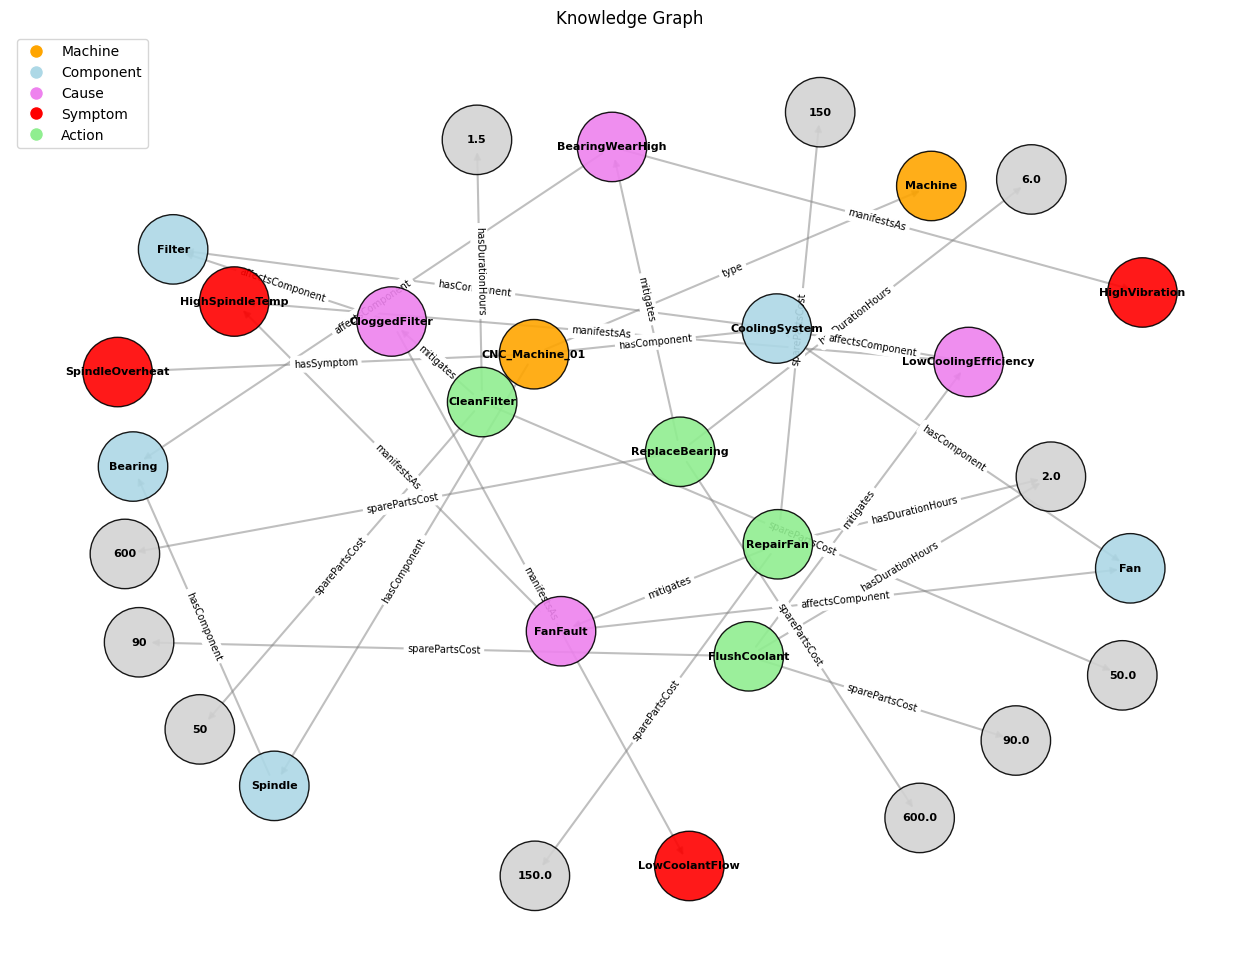

In [13]:
for s, p, o in g:
    s_name = s.split("#")[-1]
    o_name = o.split("#")[-1]
    p_name = p.split("#")[-1]
    
    # Skip definitions AND skip severity-level edges
    if p_name in ["type", "hasSeverityLevel"]:
        continue
    
    G.add_edge(s_name, o_name, label=p_name)

# --- REMOVE SEVERITY NODES COMPLETELY ---
severity_nodes = set()

for s, p, o in g:
    p_name = p.split("#")[-1]
    if p_name == "hasSeverityLevel":
        severity_nodes.add(o.split("#")[-1])

for n in severity_nodes:
    if n in G:
        G.remove_node(n)
# ----------------------------------------


# 3. "Smart" Color Assignment based on Topology
node_colors = {}

for node in G.nodes():
    # Default color
    color = "lightgray" 
    
    out_edges = G.out_edges(node, data=True)
    in_edges = G.in_edges(node, data=True)
    
    # ACTION (Green)
    is_action = False
    for u, v, data in out_edges:
        if data['label'] in ["mitigates", "sparePartsCost", "hasDurationHours"]:
            is_action = True
    if is_action:
        node_colors[node] = "lightgreen"
        continue

    # FAILURE (Violet)
    is_failure = False
    for u, v, data in out_edges:
        if data['label'] in ["manifestsAs", "affectsComponent"]:
            is_failure = True
    for u, v, data in in_edges:
        if data['label'] == "mitigates":
            is_failure = True
            
    if is_failure:
        node_colors[node] = "violet"
        continue

    # SYMPTOM (Red)
    is_symptom = False
    for u, v, data in in_edges:
        if data['label'] == "manifestsAs" or data['label'] == "hasSymptom":
            is_symptom = True
            
    if is_symptom:
        node_colors[node] = "red"
        continue

    # COMPONENT (Blue)
    is_component = False
    for u, v, data in in_edges:
        if data['label'] == "hasComponent" or data['label'] == "affectsComponent":
            is_component = True
    if is_component:
        node_colors[node] = "lightblue"
        continue
        
    # MACHINE (Orange)
    if "Machine" in node:
        node_colors[node] = "orange"
        continue


# Draw
colors = [node_colors.get(n, "lightgray") for n in G.nodes()]

plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=1.2, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=2500, node_color=colors, alpha=0.9, edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, width=1.5, alpha=0.5)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_size=7)

from matplotlib.lines import Line2D
legend_map = {"Machine": "orange", "Component": "lightblue", "Cause": "violet", "Symptom": "red", "Action": "lightgreen"}
legend_elements = [Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v, markersize=10) for k, v in legend_map.items()]
plt.legend(handles=legend_elements, loc='upper left')

plt.title("Knowledge Graph")
plt.axis("off")
plt.show()



### Another Way to see the Knowledge Graph

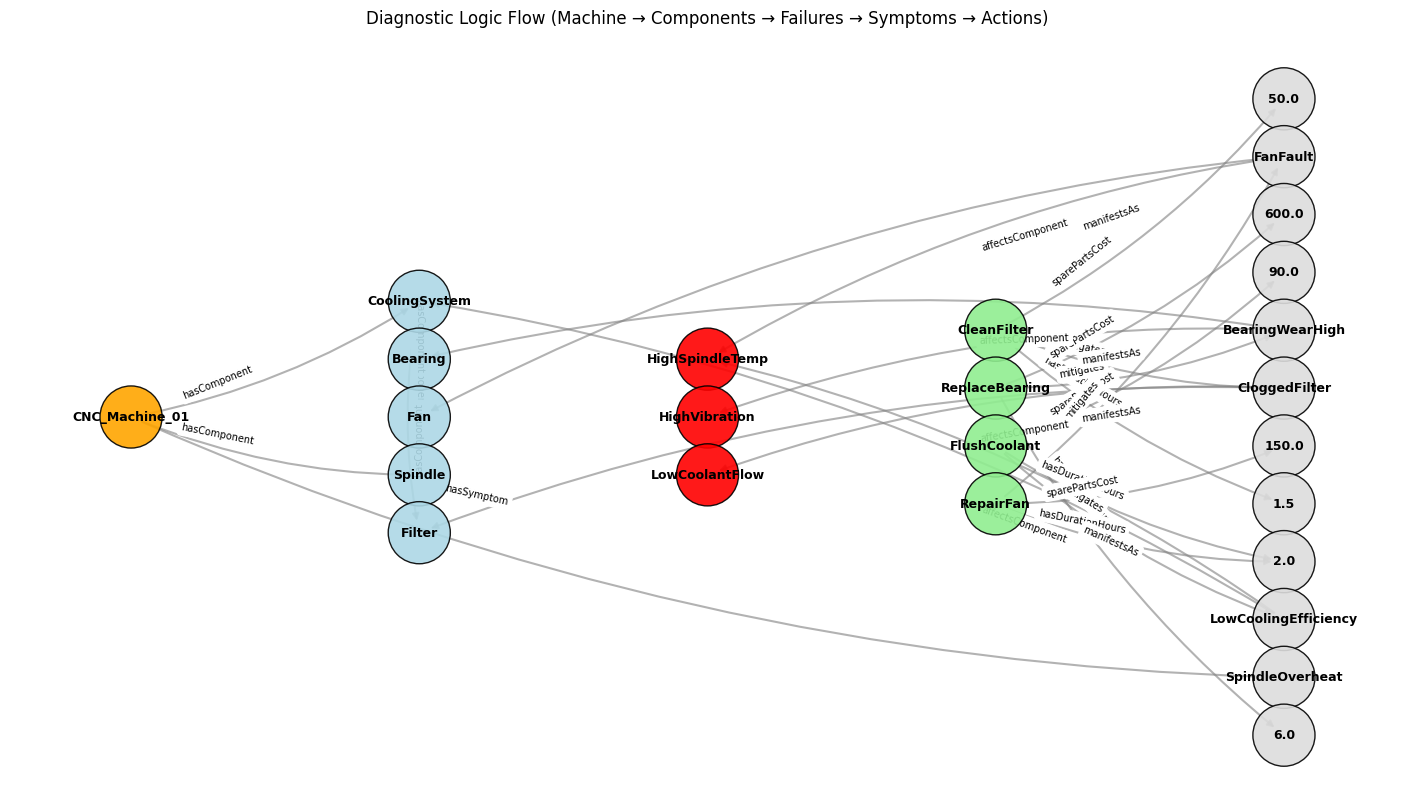

In [14]:

# 1. Load Data
g = Graph()
g.parse("ontologies/knowledge_base_protege.ttl", format="turtle")
CNC = Namespace("http://example.org/gjoli_diagnostics#")

# 2. Setup Graph
G = nx.DiGraph()

# 3. Define Layers for the Layout
layer_map = {
    "Machine": 0,
    "Component": 1,
    "Sensor": 1,
    "FailureMode": 2,
    "Symptom": 3,
    "MaintenanceAction": 4,
    "Other": 5
}

# Color Map
node_colors_map = {
    "Machine": "orange", "Component": "lightblue", "FailureMode": "violet",
    "Symptom": "red", "MaintenanceAction": "lightgreen", "Sensor": "yellow", "Other": "#ddd"
}

# 4. Build Graph & Assign Layers
entity_types = {}
for s, p, o in g.triples((None, RDF.type, None)):
    clean_type = o.split("#")[-1]
    entity_types[s.split("#")[-1]] = clean_type

# --- Collect severity nodes for removal ---
severity_nodes = set()
for s, p, o in g:
    if p.split("#")[-1] == "hasSeverityLevel":
        severity_nodes.add(o.split("#")[-1])

# Build graph
for s, p, o in g:
    p_name = p.split("#")[-1]

    # Skip severity edges
    if p_name == "hasSeverityLevel":
        continue
    
    if p == RDF.type:
        continue
    
    s_name = s.split("#")[-1]
    o_name = o.split("#")[-1]
    
    # Assign Layer Attribute
    s_type = entity_types.get(s_name, "Other")
    o_type = entity_types.get(o_name, "Other")
    
    G.add_node(s_name, layer=layer_map.get(s_type, 5))
    G.add_node(o_name, layer=layer_map.get(o_type, 5))
    
    G.add_edge(s_name, o_name, label=p_name)

# --- Remove severity nodes from the final graph ---
for node in severity_nodes:
    if node in G:
        G.remove_node(node)

# 5. Draw with Multipartite Layout
plt.figure(figsize=(18, 10))
pos = nx.multipartite_layout(G, subset_key="layer")

colors = [node_colors_map.get(entity_types.get(n, "Other"), "lightgray") for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=colors, alpha=0.9, edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

nx.draw_networkx_edges(
    G, pos, edge_color="gray", arrows=True, width=1.5, alpha=0.6,
    connectionstyle="arc3,rad=0.1"
)

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.7)

plt.title("Diagnostic Logic Flow (Machine → Components → Failures → Symptoms → Actions)")
plt.axis("off")
plt.show()


## 4.2 Merging the Knowledge Graph (TBox + ABox)

In this step, we combine two distinct components of our system into a single artifact:

- The Schema (TBox): The logical rules and definitions (Classes, Properties, Axioms) defined in **ontology_schema.ttl**, in PROTEGÉ;
- The Data (ABox): The specific instances (Machine, Components, Failures) generated from our CSVs in **knowledge_base_protege.ttl** .

-> We merge them into a single OWL file (cnc_final.owl) 

In [15]:
from rdflib import Graph
import os

# ==========================================
# 1. INITIALIZATION
# ==========================================
# We create an empty graph to act as the container for our merged knowledge.
merged_graph = Graph()

# Define file paths
schema_file = "ontologies/ontology_schema.ttl"       # TBox (Rules)
data_file = "ontologies/knowledge_base_protege.ttl"  # ABox (Data)
output_file = "ontologies/cnc_final.owl"             # Final Artifact

# ==========================================
# 2. LOAD SCHEMA (TBox)
# ==========================================
# This file contains the "Brain" of the system (Class hierarchy, Logic rules).
if os.path.exists(schema_file):
    try:
        merged_graph.parse(schema_file, format="turtle")
        print(f" Loaded Schema: {schema_file}")
    except Exception as e:
        print(f" ERROR parsing schema: {e}")
else:
    print(f" ERROR: File not found: {schema_file}")

# ==========================================
# 3. LOAD DATA (ABox)
# ==========================================
# This file contains the "Memory" of the system (Specific machine state).
if os.path.exists(data_file):
    try:
        merged_graph.parse(data_file, format="turtle")
        print(f" Loaded Data: {data_file}")
    except Exception as e:
        print(f" ERROR parsing data: {e}")
else:
    print(f" ERROR: File not found: {data_file}")

# ==========================================
# 4. EXPORT MERGED ONTOLOGY
# ==========================================
# We save the result as RDF/XML, which is the standard format for OWL Reasoners.
# This file is what you will load into Protegé or the Python Reasoner.

try:
    merged_graph.serialize(destination=output_file, format="xml")
    print("\n" + "="*40)
    print(f"SUCCESS: Merged Ontology saved to '{output_file}'")
    print(f"Total Triples: {len(merged_graph)}")
    print("="*40)
except Exception as e:
    print(f" ERROR saving file: {e}")

 Loaded Schema: ontologies/ontology_schema.ttl
 Loaded Data: ontologies/knowledge_base_protege.ttl

SUCCESS: Merged Ontology saved to 'ontologies/cnc_final.owl'
Total Triples: 171


## 4.3 Logic Verification

In this section, we verify whether the ontology behaves logically as intended.
We do this by loading the ontology, running a description-logic reasoner, and checking the inferences it makes.

Unlike normal code, here we are not “manually labeling things”.
Instead, we let the ontology engine decide what is true based on the rules we defined earlier.

We begin by loading the ontology file again "cnc_final.owl", and before reasoning we print all classes to confirm:

- The ontology loaded correctly;

- The names and IRIs match expectations;

- Nothing is missing;

In [3]:
# Load the file again
onto = get_ontology("ontologies/cnc_final.owl").load()

# Print all classes found
print("--- CLASSES FOUND IN ONTOLOGY ---")
for cls in onto.classes():
    print(cls.name, "->", cls.iri)

--- CLASSES FOUND IN ONTOLOGY ---
MaintenanceAction -> http://example.org/gjoli_diagnostics#MaintenanceAction
Component -> http://example.org/gjoli_diagnostics#Component
Spindle -> http://example.org/gjoli_diagnostics#Spindle
CoolingSystem -> http://example.org/gjoli_diagnostics#CoolingSystem
Fan -> http://example.org/gjoli_diagnostics#Fan
Filter -> http://example.org/gjoli_diagnostics#Filter
Machine -> http://example.org/gjoli_diagnostics#Machine
ObservableEntity -> http://example.org/gjoli_diagnostics#ObservableEntity
Sensor -> http://example.org/gjoli_diagnostics#Sensor
Event -> http://example.org/gjoli_diagnostics#Event
Symptom -> http://example.org/gjoli_diagnostics#Symptom
SpindleOverheat -> http://example.org/gjoli_diagnostics#SpindleOverheat
FailureMode -> http://example.org/gjoli_diagnostics#FailureMode
Measurement -> http://example.org/gjoli_diagnostics#Measurement
LowCoolantFlow -> http://example.org/gjoli_diagnostics#LowCoolantFlow
CriticalSymptom -> http://example.org/gjol

Next, we will run the HermiT reasoner to validate that our rules (TBox) are correctly classifying our data (ABox). The reasoner uses:

- The TBox (ontology rules and definitions)
- The ABox (instances and data)

We verify whether the reasoner correctly applies the logical rules  we defined in the ontology TBox (created in Protégé). After loading the ontology and running the reasoner, we test three behaviors:

- **Critical symptoms**:
Symptoms with severity “High” must be inferred as CriticalSymptom.

- **Costly repairs**:
Maintenance actions with spare-parts cost ≥ 500 must be inferred as CostlyRepair.

- **Overheated machines**:
Any machine that has the symptom SpindleOverheat must be inferred as OverheatedMachine.

These checks can confirm that the TBox is working correctly: the graph is not only storing instances, but using ontology rules to derive new knowledge.

In [17]:


# RUN THE REASONER
# You were missing this block! Without it, inferences are never calculated.
print("Running Reasoner...")
with onto:
    sync_reasoner()

print("--- INFERENCE VERIFICATION ---")

# TEST A: Critical Symptoms
# Rule: CriticalSymptom = Symptom AND hasSeverityLevel value "High"
target_class = onto.search_one(iri="*CriticalSymptom")
if target_class:
    results = target_class.instances()
    print(f"[1] Critical Symptoms Found: {len(results)}")
    for i in results:
        severity = i.hasSeverityLevel[0] if i.hasSeverityLevel else "Unknown"
        print(f"    - {i.name} (Severity: {severity})")
else:
    print("[1] CriticalSymptom class not found.")

# TEST B: Costly Repairs
# Rule: CostlyRepair = MaintenanceAction AND sparePartsCost >= 500.0
target_class = onto.search_one(iri="*CostlyRepair")
if target_class:
    results = target_class.instances()
    print(f"[2] Costly Repairs Found: {len(results)}")
    for i in results:
        cost = i.sparePartsCost[0] if i.sparePartsCost else 0.0
        print(f"    - {i.name} (Cost: {cost})")
else:
    print("[2] CostlyRepair class not found.")

# TEST C: Machine Diagnosis (The "Overheated" Scenario)
# Rule: OverheatedMachine = Machine AND hasSymptom value SpindleOverheat
target_class = onto.search_one(iri="*OverheatedMachine")
if target_class:
    results = target_class.instances()
    print(f"[3] Overheated Machines Detected: {len(results)}")
    for i in results:
        print(f"    - {i.name} (Status: Critical)")
else:
    print("[3] OverheatedMachine class not found.")

Running Reasoner...


* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /Users/gjoli/Desktop/uni/TSI/project/.venv/lib/python3.9/site-packages/owlready2/hermit:/Users/gjoli/Desktop/uni/TSI/project/.venv/lib/python3.9/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/z0/pm53wfh91kxgn3slf8sv896r0000gn/T/tmp6n_eg934


--- INFERENCE VERIFICATION ---
[1] Critical Symptoms Found: 2
    - HighSpindleTemp (Severity: High)
    - HighVibration (Severity: Unknown)
[2] Costly Repairs Found: 1
    - ReplaceBearing (Cost: 600.0)
[3] Overheated Machines Detected: 1
    - CNC_Machine_01 (Status: Critical)


* Owlready2 * HermiT took 0.5968410968780518 seconds
* Owlready * Reparenting cnc_final.OverheatedMachine: {owl.Thing} => {cnc_final.Machine}
* Owlready * Reparenting cnc_final.HighVibration: {cnc_final.Symptom} => {cnc_final.CriticalSymptom, cnc_final.Symptom}
* Owlready * Reparenting cnc_final.CriticalSymptom: {owl.Thing} => {cnc_final.Symptom}
* Owlready * Reparenting cnc_final.CostlyRepair: {owl.Thing} => {cnc_final.MaintenanceAction}
* Owlready * Reparenting cnc_final.Spindle: {cnc_final.Component} => {cnc_final.Machine, cnc_final.Component}
* Owlready * Reparenting cnc_final.CoolingSystem: {cnc_final.Component} => {cnc_final.Machine, cnc_final.Component}
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


The reasoner successfully applied the TBox rules: it automatically classified critical symptoms, costly repairs, and overheated machines, and updated the class hierarchy accordingly. This confirms that the ontology logic is consistent and that new knowledge is being correctly inferred from the existing data.

We then check if each MaintenanceAction instance is correctly linked to the failures it mitigates through the mitigates property

In [4]:
action_class = onto.search_one(iri="*MaintenanceAction")

if action_class:
    print(f"\n[4] Maintenance Knowledge Graph Links:")
    found_links = False
    for proc in action_class.instances():
        # Check if the 'mitigates' relationship exists
        if hasattr(proc, 'mitigates') and proc.mitigates:
            for failure in proc.mitigates:
                print(f"    - {proc.name} --(mitigates)--> {failure.name}")
                found_links = True
    
    if not found_links:
        print("    - No mitigation links found. (Check data generation script).")
else:
    print("\n[4] Error: Class 'MaintenanceAction' not found.")


[4] Maintenance Knowledge Graph Links:
    - RepairFan --(mitigates)--> FanFault
    - CleanFilter --(mitigates)--> CloggedFilter
    - FlushCoolant --(mitigates)--> LowCoolingEfficiency
    - ReplaceBearing --(mitigates)--> BearingWearHigh


## 4.4 Query Knowledge Graph to identify possible maintenance procedures

### 1) Check if KG correctly connects causes -> maintainence plan + costs + time

In [5]:
def get_maintenance_plan(predicted_failure_name):
    """
    Input: The name of the failure predicted by the Bayesian Network (e.g., "BearingWearHigh")
    Output: Prints the recommended action, cost, duration, AND the component affected.
    """
    # 1. Search for the Failure Mode in the Ontology
    failure = onto.search_one(iri=f"*{predicted_failure_name}")
    
    if not failure:
        return f"Error: Failure '{predicted_failure_name}' not found in Knowledge Graph."

    # 1.5 FIND AFFECTED COMPONENT
    # We look for the 'affectsComponent' property on the failure object
    affected_component = "Unknown"
    if hasattr(failure, "affectsComponent") and failure.affectsComponent:
        # It returns a list, so we grab the first item
        affected_component = failure.affectsComponent[0].name

    print(f" Bayesian Network detected: {failure.name}")
    print(f"   -> Diagnosis: This failure damages the '{affected_component}'.")
    
    # 2. Find the Action that mitigates this Failure
    actions = onto.search(type=onto.MaintenanceAction)
    
    recommended_action = None
    for action in actions:
        if hasattr(action, 'mitigates') and failure in action.mitigates:
            recommended_action = action
            break
    
    # 3. Format and Return the Result
    if recommended_action:
        cost = recommended_action.sparePartsCost[0] if recommended_action.sparePartsCost else 0
        duration = recommended_action.hasDurationHours[0] if recommended_action.hasDurationHours else 0
        
        return f" Recommended action: {recommended_action.name} ({duration}h, {cost}€)."
    else:
        return f"No maintenance action defined for {failure.name}."



In [6]:
# Simulating the BN Output
bn_prediction_1 = "BearingWearHigh" 
print(get_maintenance_plan(bn_prediction_1))

bn_prediction_2 = "FanFault"
print(get_maintenance_plan(bn_prediction_2))

bn_prediction_3 = "CloggedFilter"
print(get_maintenance_plan(bn_prediction_3))

bn_prediction_4 = "LowCoolingEfficiency"
print(get_maintenance_plan(bn_prediction_4))

 Bayesian Network detected: BearingWearHigh
   -> Diagnosis: This failure damages the 'Bearing'.
 Recommended action: ReplaceBearing (6.0h, 600.0€).
 Bayesian Network detected: FanFault
   -> Diagnosis: This failure damages the 'Fan'.
 Recommended action: RepairFan (2.0h, 150.0€).
 Bayesian Network detected: CloggedFilter
   -> Diagnosis: This failure damages the 'Filter'.
 Recommended action: CleanFilter (1.5h, 50.0€).
 Bayesian Network detected: LowCoolingEfficiency
   -> Diagnosis: This failure damages the 'CoolingSystem'.
 Recommended action: FlushCoolant (2.0h, 90.0€).


### 2. Bayesian Input → Knowledge Graph Query ( SIMULATION )

In this section, we simulate how the system supports maintenance planning.

- The Bayesian Network produces a list of possible failures with probabilities.

- The Knowledge Graph is then used to retrieve, for each failure:

    - the most likely cause

    - the maintenance action that mitigates it

    -spare-parts cost

    - expected duration of the repair

Instead of always repairing, we evaluate three possible decisions:

    continue · slow down · schedule maintenance

The objective is to choose the option that leads to the lowest expected cost.

**NOTE** : The following cost-related parameters are illustrative only and were chosen to demonstrate the decision logic:

- hourly_downtime_cost = 80 € / hour
Estimated loss when the machine is stopped

- failure_cost_default = 2000 €
Approximate cost if the failure actually occurs

- slowdown_factor = 0.5
Slowing down reduces failure risk by ~50%

- slowdown_penalty_per_hour = 40 € / hour
Productivity loss while running slower

In real industrial systems, these values would come from production logs, maintenance records, and financial estimates — and would typically be tuned per machine and per failure type.

#### A ) Strategy A

> **> Strategy A — Expected-Cost Decision on the Most Probable Failure**

We first select the failure with the highest probability (according to the BN), then compare:


Instead of always repairing, we compare the expected cost of three actions:

| Decision                 | What happens                      | Expected cost formula                                               |
| ------------------------ | --------------------------------- | ------------------------------------------------------------------- |
| **Continue**             | Keep running normally             | `Probability × Failure cost`                                        |
| **Slow down**            | Reduce risk but lose productivity | `(Probability × slowdown_factor × Failure cost) + slowdown_penalty` |
| **Schedule maintenance** | Pay repair + downtime now         | `sparePartsCost + (duration × hourly_downtime_cost)`                |


For each option we estimate its expected cost, and Strategy A recommends the one with the minimum total cost.

In [15]:
def optimize_maintenance_plan_A(
    bn_probabilities,
    hourly_downtime_cost=80.0,
    failure_cost_default=2000.0,
    slowdown_factor=0.5,          # risk reduction when slowing down
    slowdown_penalty_per_hour=40, # productivity loss per hour when slowing

):
    """
    Strategy A + Expected-Cost Decision:
    Pick the highest-probability failure, then choose
    (continue | slow down | schedule maintenance)
    based on minimal expected cost.
    """

    if not bn_probabilities:
        print("No BN probabilities provided.")
        return

    # 1️Pick failure with highest probability
    cause_name, probability = max(bn_probabilities.items(), key=lambda x: x[1])
    print(f"\n[Strategy A] Highest Probability Failure: {cause_name} ({probability:.1%})")

    # 2️ Find failure in KG
    failure = onto.search_one(iri=f"*{cause_name}")
    if not failure:
        print(f" Warning: Failure '{cause_name}' not found in KG.")
        return

    # Try to get failure cost from KG (fallback to default)
    failure_cost = getattr(failure, "failureCost", [failure_cost_default])[0]

    # 3️Find maintenance action
    action = None
    for a in onto.search(type=onto.MaintenanceAction):
        if hasattr(a, 'mitigates') and failure in a.mitigates:
            action = a
            break

    if not action:
        print("  No maintenance action linked to this failure.")
        return

    # Extract values
    part_cost = action.sparePartsCost[0] if action.sparePartsCost else 0.0
    duration = action.hasDurationHours[0] if action.hasDurationHours else 0.0

    # --------------------------------------------------------
    #  EXPECTED COSTS FOR THE THREE DECISIONS
    # --------------------------------------------------------

    # 1) Continue — risk remains
    cost_continue = probability * failure_cost

    # 2) Slow down — reduce risk but lose productivity
    cost_slow = (probability * slowdown_factor * failure_cost) + (
        slowdown_penalty_per_hour 
    )

    # 3) Schedule maintenance now — pay the repair + downtime
    cost_maint = part_cost + (duration * hourly_downtime_cost)

    options = [
        ("Continue", cost_continue),
        ("Slow down", cost_slow),
        ("Schedule maintenance", cost_maint),
    ]

    # Pick minimum expected cost
    best_action, best_cost = min(options, key=lambda x: x[1])

    # --------------------------------------------------------
    #  Results
    # --------------------------------------------------------
    print("\nDecision options (expected cost):")
    print(f"  Continue:              €{cost_continue:.0f}")
    print(f"  Slow down:             €{cost_slow:.0f}")
    print(f"  Schedule maintenance:  €{cost_maint:.0f}")

    print("\n=======================================")
    print(f" RECOMMENDED ACTION: {best_action.upper()}")
    print(" (Minimizes expected total cost)")
    print("=======================================")

    print("\nContext:")
    print(f"  Cause: {cause_name}")
    print(f"  Prob:  {probability:.1%}")
    print(f"  Parts cost: €{part_cost:.0f}")
    print(f"  Duration:   {duration}h")



In [16]:
# --- TEST THE SMART LOGIC ---

# Example: The BN is unsure. It thinks it's Bearing Wear (60%) or Clogged Filter (30%).
# (The 'FanFault' is unlikely at 10%)
mock_bn_output = {
    "BearingWearHigh": 0.60,
    "CloggedFilter": 0.30,
    "FanFault": 0.10
}

optimize_maintenance_plan_A(mock_bn_output)


[Strategy A] Highest Probability Failure: BearingWearHigh (60.0%)

Decision options (expected cost):
  Continue:              €1200
  Slow down:             €640
  Schedule maintenance:  €1080

 RECOMMENDED ACTION: SLOW DOWN
 (Minimizes expected total cost)

Context:
  Cause: BearingWearHigh
  Prob:  60.0%
  Parts cost: €600
  Duration:   6.0h


#### B) Strategy B - Cost-Aware Optimization Across All Failures


Strategy B extends the idea of A.

Instead of considering only the most probable failure, we:

- evaluate all failures predicted by the BN

- compute the expected cost of continue / slow-down / maintenance for each

- select the cheapest decision per failure

- rank failures according to their best expected cost

This balances both:

- Probability of occurrence

- Financial consequences of each decision

- And prioritizes the actions that save the most money overall.

In [19]:
def optimize_maintenance_plan_B(
    bn_probabilities,
    hourly_downtime_cost=80.0,
    failure_cost_default=2000.0,
    slowdown_factor=0.5,
    slowdown_penalty_per_hour=40,
    decision_horizon_hours=4
):
    """
    Strategy B — Cost-Aware + Expected-Cost Decision
    
    For each possible failure:
      - retrieve maintenance action from KG
      - compute expected cost of:
          (continue | slow down | schedule maintenance)
      - choose the cheapest option
    Finally, rank failures by lowest expected cost.
    """

    ranked_options = []

    for cause_name, probability in bn_probabilities.items():

        #  Get failure
        failure = onto.search_one(iri=f"*{cause_name}")
        if not failure:
            print(f" Warning: Cause '{cause_name}' not found in KG.")
            continue

        # failure cost (fallback if missing)
        failure_cost = getattr(failure, "failureCost", [failure_cost_default])[0]

        # Find maintenance action
        action = None
        for a in onto.search(type=onto.MaintenanceAction):
            if hasattr(a, 'mitigates') and failure in a.mitigates:
                action = a
                break

        if not action:
            print(f"  No maintenance action linked for {cause_name}.")
            continue

        part_cost = action.sparePartsCost[0] if action.sparePartsCost else 0.0
        duration  = action.hasDurationHours[0] if action.hasDurationHours else 0.0

        # ----------------------------------------------------
        #  Expected-cost evaluation for each decision
        # ----------------------------------------------------

        cost_continue = probability * failure_cost

        cost_slow = (probability * slowdown_factor * failure_cost) + (
            slowdown_penalty_per_hour * decision_horizon_hours
        )

        cost_maint = part_cost + (duration * hourly_downtime_cost)

        options = [
            ("Continue", cost_continue),
            ("Slow down", cost_slow),
            ("Schedule maintenance", cost_maint)
        ]

        best_decision, best_cost = min(options, key=lambda x: x[1])

        ranked_options.append({
            "failure": cause_name,
            "prob": probability,
            "decision": best_decision,
            "expected_cost": best_cost,
            "parts": part_cost,
            "time": duration
        })

    # Rank failures by lowest expected total cost
    ranked_options.sort(key=lambda x: x['expected_cost'])

    # ----------------------------------------------------
    #  Output
    # ----------------------------------------------------
    print(f"{'FAILURE':<18} | {'PROB':<6} | {'DECISION':<20} | EXPECTED COST")
    print("-" * 75)

    for opt in ranked_options:
        print(f"{opt['failure']:<18} | {opt['prob']:.1%} | {opt['decision']:<20} | €{opt['expected_cost']:.0f}")


In [20]:
# --- TEST THE SMART LOGIC ---

# Example: The BN is unsure. It thinks it's Bearing Wear (60%) or Clogged Filter (30%).
# (The 'FanFault' is unlikely at 10%)
mock_bn_output = {
    "BearingWearHigh": 0.60,
    "CloggedFilter": 0.30,
    "FanFault": 0.10
}

optimize_maintenance_plan_B(mock_bn_output)

FAILURE            | PROB   | DECISION             | EXPECTED COST
---------------------------------------------------------------------------
CloggedFilter      | 30.0% | Schedule maintenance | €170
FanFault           | 10.0% | Continue             | €200
BearingWearHigh    | 60.0% | Slow down            | €760
